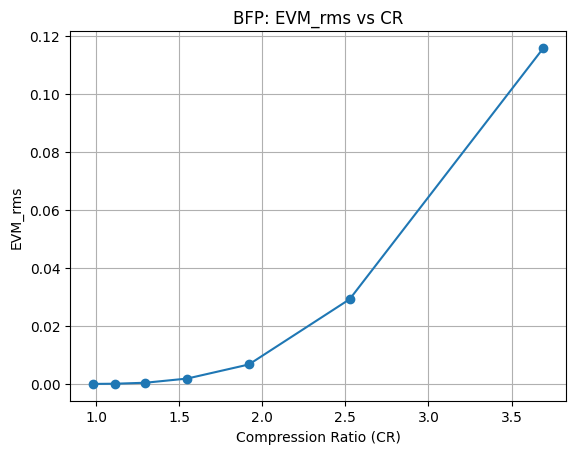

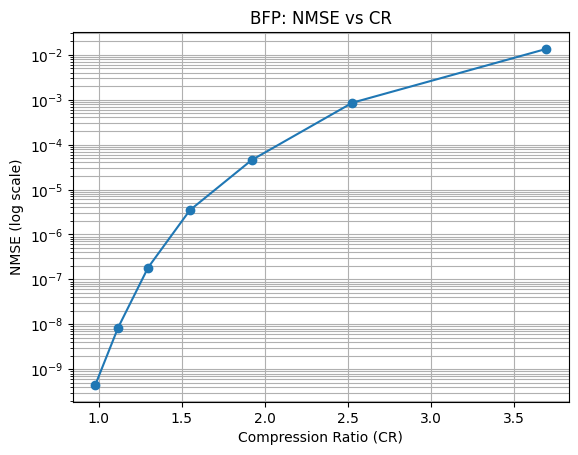

In [171]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TX_PRE = "tx/pre-comp.bin"   # 你唯一的参考
RX_DIR = "bfp"  # 里面有 wiqout6/ wiqout8/ ... 或者别的结构

WIQIN = 16
BLOCK_LEN = 12
UD_BITS_PER_BLOCK = 8

wiqout_list = [16, 14, 12, 10, 8, 6, 4]  # 按你的实验点改

def bfp_cr(wiqin: int, wiqout: int, block_len: int = 12, ud_bits: int = 8) -> float:
    raw_bits = 2 * wiqin * block_len
    comp_bits = 2 * wiqout * block_len + ud_bits
    return raw_bits / comp_bits

def read_c64(path: str) -> np.ndarray:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    x = np.fromfile(path, dtype=np.complex64)
    if x.size == 0:
        raise RuntimeError(f"Empty file: {path}")
    return x

def evm_nmse_ref(x_ref: np.ndarray, y: np.ndarray):
    n = min(len(x_ref), len(y))
    x = x_ref[:n]
    y = y[:n]
    e = y - x
    nmse = float(np.mean(np.abs(e)**2) / np.mean(np.abs(x)**2))
    evm_rms = float(np.sqrt(nmse))
    return evm_rms, nmse, n

def post_path_of(wiqout: int) -> str:
    return f"{RX_DIR}/rx_wiqout{wiqout}.bin"

x_ref = read_c64(TX_PRE)

rows = []
for wiqout in wiqout_list:
    post_path = post_path_of(wiqout)
    y = read_c64(post_path)

    evm_rms, nmse, n = evm_nmse_ref(x_ref, y)
    cr = bfp_cr(WIQIN, wiqout, BLOCK_LEN, UD_BITS_PER_BLOCK)

    rows.append({
        "WIQOUT": wiqout,
        "CR": cr,
        "EVM_rms": evm_rms,
        "NMSE": nmse,
        "n_samples_compared": n,
        "post_path": post_path
    })

df = pd.DataFrame(rows).sort_values("CR")
df

plt.figure()
plt.plot(df["CR"], df["EVM_rms"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("EVM_rms")
plt.grid(True)
plt.title("BFP: EVM_rms vs CR")
plt.show()

plt.figure()
plt.semilogy(df["CR"], df["NMSE"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("NMSE (log scale)")
plt.grid(True, which="both")
plt.title("BFP: NMSE vs CR")
plt.show()


file size (bytes): 4900028
as float32:
  num samples: 1225007
  min / max : 0.0032973657 100.000015
  first 10  : [100.000015 100.000015  99.95334   99.87728   99.92794   99.67907
  98.40211   92.408676  76.405304  63.750504]

as float64:
  num samples: 612503
  min / max : 7.972752123616414e-23 52776633995264.016
  first 10  : [5.27766340e+13 5.22368438e+13 5.13650997e+13 2.72869718e+13
 2.13044246e+12 5.27853687e+12 2.65732911e+12 1.92294605e+12
 2.77648090e+12 7.16523967e+12]
Raw EVM statistics:
  mean : 10.733263317570694
  std  : 18.135137580404706
  min  : 0.0032973657362163067
  max  : 100.00001525878906

After removing top 5% EVM samples:
  threshold (95th percentile): 32.06092910766593
  kept ratio : 0.9499994693907872
  mean       : 6.80382117946864
  std        : 3.8974081876722058
  min        : 0.0032973657362163067
  max        : 32.05955123901367


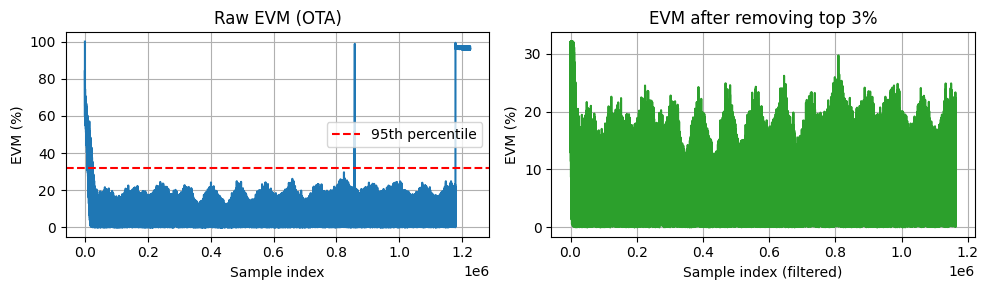

In [172]:
import os
import numpy as np

path = "evm/evm_wiqout6.bin"

print("file size (bytes):", os.path.getsize(path))

# 先假设是 float32
x32 = np.fromfile(path, dtype=np.float32)
print("as float32:")
print("  num samples:", x32.size)
print("  min / max :", x32.min(), x32.max())
print("  first 10  :", x32[:10])

# 再试试 float64（防止你 File Sink 设成了 double）
x64 = np.fromfile(path, dtype=np.float64)
print("\nas float64:")
print("  num samples:", x64.size)
print("  min / max :", x64.min(), x64.max())
print("  first 10  :", x64[:10])

import matplotlib.pyplot as plt

evm = x32.astype(float)

# ---------- 原始统计 ----------
print("Raw EVM statistics:")
print("  mean :", evm.mean())
print("  std  :", evm.std())
print("  min  :", evm.min())
print("  max  :", evm.max())

# ---------- 去掉前 5%（最大的 5%） ----------
p95 = np.percentile(evm, 95)
mask = evm <= p95
evm_trim = evm[mask]

print("\nAfter removing top 5% EVM samples:")
print("  threshold (95th percentile):", p95)
print("  kept ratio :", evm_trim.size / evm.size)
print("  mean       :", evm_trim.mean())
print("  std        :", evm_trim.std())
print("  min        :", evm_trim.min())
print("  max        :", evm_trim.max())

# ---------- 可视化 ----------
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(evm, color="tab:blue")
plt.axhline(p95, color="r", linestyle="--", label="95th percentile")
plt.title("Raw EVM (OTA)")
plt.xlabel("Sample index")
plt.ylabel("EVM (%)")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(evm_trim, color="tab:green")
plt.title("EVM after removing top 3%")
plt.xlabel("Sample index (filtered)")
plt.ylabel("EVM (%)")
plt.grid(True)

plt.tight_layout()
plt.show()



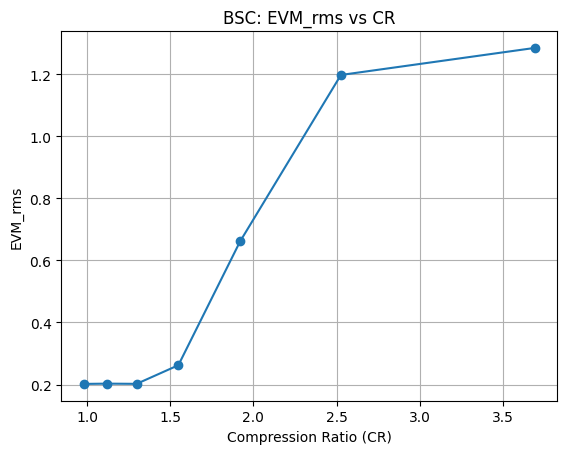

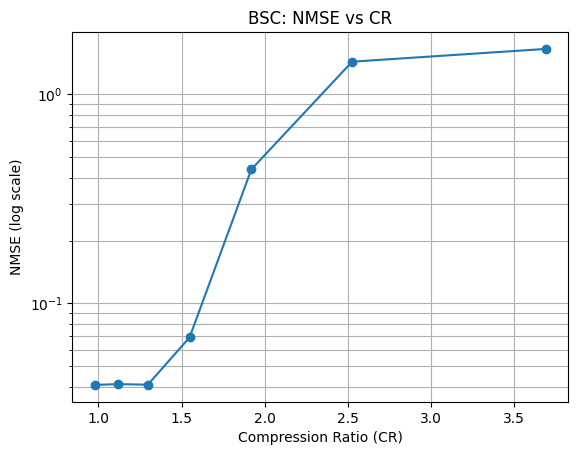

In [173]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TX_PRE = "tx/pre-comp.bin"   # 你唯一的参考
RX_DIR = "bsc"               # 改成你的 BSC 输出目录：里面有 rx_wiqout16.bin / rx_wiqout12.bin / ...

WIQIN = 16
BLOCK_LEN = 12
UD_BITS_PER_BLOCK = 8        # BSC: scaler per block stored as 1 byte (8 bits)

wiqout_list = [16, 14, 12, 10, 8, 6, 4]  # 按你的实验点改


def bsc_cr(wiqin: int, wiqout: int, block_len: int = 12, ud_bits: int = 8) -> float:
    """
    BSC/BS compression ratio:
      raw bits per block  = 2*WIQIN*BLOCK_LEN
      comp bits per block = 2*WIQOUT*BLOCK_LEN + ud_bits
    (ud_bits=8 because scaler is 1 byte per block)
    """
    raw_bits = 2 * wiqin * block_len
    comp_bits = 2 * wiqout * block_len + ud_bits
    return raw_bits / comp_bits


def read_c64(path: str) -> np.ndarray:
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    x = np.fromfile(path, dtype=np.complex64)
    if x.size == 0:
        raise RuntimeError(f"Empty file: {path}")
    return x


def evm_nmse_ref(x_ref: np.ndarray, y: np.ndarray):
    n = min(len(x_ref), len(y))
    x = x_ref[:n]
    y = y[:n]
    e = y - x
    nmse = float(np.mean(np.abs(e)**2) / np.mean(np.abs(x)**2))
    evm_rms = float(np.sqrt(nmse))
    return evm_rms, nmse, n


def post_path_of(wiqout: int) -> str:
    return f"{RX_DIR}/rx_wiqout{wiqout}.bin"


# ===== run =====
x_ref = read_c64(TX_PRE)

rows = []
for wiqout in wiqout_list:
    post_path = post_path_of(wiqout)
    y = read_c64(post_path)

    evm_rms, nmse, n = evm_nmse_ref(x_ref, y)
    cr = bsc_cr(WIQIN, wiqout, BLOCK_LEN, UD_BITS_PER_BLOCK)

    rows.append({
        "WIQOUT": wiqout,
        "CR": cr,
        "EVM_rms": evm_rms,
        "NMSE": nmse,
        "n_samples_compared": n,
        "post_path": post_path
    })

df_bsc = pd.DataFrame(rows).sort_values("CR")
df_bsc

plt.figure()
plt.plot(df_bsc["CR"], df_bsc["EVM_rms"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("EVM_rms")
plt.grid(True)
plt.title("BSC: EVM_rms vs CR")
plt.show()

plt.figure()
plt.semilogy(df_bsc["CR"], df_bsc["NMSE"], marker="o")
plt.xlabel("Compression Ratio (CR)")
plt.ylabel("NMSE (log scale)")
plt.grid(True, which="both")
plt.title("BSC: NMSE vs CR")
plt.show()

